In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from core import * # basic imports
from data_manipulation import DataBatches, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import OptimizerWrapper, TrainingPolicy, FinderPolicy, validate_multilabel
# from __dataBatches__ import *
import warnings; warnings.filterwarnings('ignore')

# MURA Pretrained

In [3]:
pretrained = True
batch_size = 16
epochs = 8
freeze = False

random_states = [42]

PATH = Path('../data')
SAVE_DIRECTORY = Path('../latest_models/14diseases-app2')
SAVE_PLOT = Path('../latest_plots/14diseases-app2')

img_folder_path = PATH/'ChestXRay-250'
data = '14diseases'

# Data Loaders

In [4]:
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")


train_dl = DataBatches(train_df, img_folder_path=img_folder_path,
                               transforms=True, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

valid_dl = DataBatches(valid_df,img_folder_path=img_folder_path,
                     transforms = False, shuffle = False, data= data,
                     batch_size = batch_size, normalize=pretrained)

test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = True, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)


In [5]:
train_dl.set_random_choices()

In [6]:
x,y = next(iter(train_dl))

In [7]:
x.shape, y.shape

(torch.Size([16, 3, 234, 234]), torch.Size([16, 14]))

# Architecture

In [8]:
model = DenseNet121(14, pretrained=pretrained, freeze=freeze).cuda()

# LR Finder

In [9]:
# LR finder loop
def lr_finder(model, n_epochs, train_dl, min_lr=1e-7, max_lr=10, save_path=None,
              alpha=1./3, early_stopping=200):

    if save_path: save_model(model, save_path)
    model.train()
    
    policy = FinderPolicy(n_epochs=n_epochs, dl=train_dl, min_lr=min_lr, max_lr=max_lr, alpha=alpha)
    optimizer = OptimizerWrapper(model, policy)

    lrs = optimizer.policy.lr_schedule
    
    losses = []
    cnt = 0

    for _ in tqdm_notebook(range(n_epochs)):
        train_dl.set_random_choices()
        for it, (x, y) in enumerate(tqdm_notebook(train_dl)):

            optimizer.zero_grad()

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if it%200 == 199: lr_loss_plot(lrs, losses)
            if cnt==early_stopping: return lrs[:cnt], losses
            cnt +=1

    if save_path: load_model(model, p)

    return lrs, losses

A Jupyter Widget

A Jupyter Widget

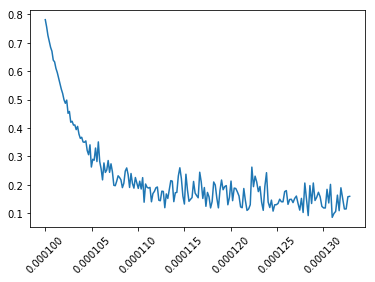

In [10]:
model = DenseNet121(14, pretrained=pretrained, freeze=freeze).cuda()
lrs, losses  = lr_finder(model, 1, train_dl, min_lr=1e-4, max_lr=1e-1, early_stopping=200)

# Training definitions

In [12]:
# def compute_AUCs(y, pred):
#     AUROCs = []
#     for i in range(N_CLASSES):
#         auc_i = roc_auc_score(y[:, i].astype(int), pred[:, i])
#         AUROCs.append(auc_i)
#     return  np.mean(AUROCs)

# def ave_auc(probs, ys):
#     aucs = [roc_auc_score(ys[:,i], probs[:,i]) for i in range(probs.shape[1])]
#     return np.mean(aucs), aucs   


# def validate(model, valid_dl):
    
#     model.eval()
#     total = 0
#     sum_loss = 0
#     ys = []
#     preds = []
    
#     for x, y in valid_dl:
        
#         out = model(x)
#         loss = F.binary_cross_entropy_with_logits(out, y)
        
#         batch = y.shape[0]
#         sum_loss += batch * (loss.item())
#         total += batch
        
#         preds.append( out.detach().cpu().numpy())
#         ys.append( y.long().cpu().numpy())

 
        
#     preds = np.vstack(preds)
#     ys = np.vstack(ys)
#     mean_auc, aucs = ave_auc(preds, ys)
    
# #     print('\n'.join([f'{m:.3f}' for m in auc])+'\n')
    
#     return sum_loss / total, mean_auc, aucs

def train(n_epochs, train_dl, valid_dl, model, div_factor=25., max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in tqdm_notebook(range(n_epochs), ):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for i, (x, y) in enumerate(tqdm_notebook(train_dl, leave=False)):

            if unfreeze_during_loop:
                if i == first_unfreeze: model.unfreeze(1)
                if i == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch


        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

# Training

In [16]:
# Whole dataset

freeze = True

transforms=[RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]

train_dl = DataBatches(train_df, img_folder_path=img_folder_path,transforms=transforms,
                       shuffle=True, data=data, batch_size=batch_size, normalize=pretrained)

model = DenseNet121(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.1663 -  val loss 0.1519 AUC 0.7481


A Jupyter Widget

Ep. 2 - train loss 0.1424 -  val loss 0.1477 AUC 0.7915


A Jupyter Widget

Ep. 3 - train loss 0.1389 -  val loss 0.1430 AUC 0.8061


A Jupyter Widget

Ep. 4 - train loss 0.1347 -  val loss 0.1455 AUC 0.8083


A Jupyter Widget

Ep. 5 - train loss 0.1308 -  val loss 0.1413 AUC 0.8180


A Jupyter Widget

Ep. 6 - train loss 0.1266 -  val loss 0.1407 AUC 0.8240


A Jupyter Widget

Ep. 7 - train loss 0.1222 -  val loss 0.1401 AUC 0.8246


A Jupyter Widget

Ep. 8 - train loss 0.1190 -  val loss 0.1408 AUC 0.8234


In [ ]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path, transforms = True, 
                      shuffle = False, data=data, batch_size = batch_size, normalize=pretrained)
TTA_multilabel(model, test_dl)

# Train spectrum

In [ ]:
train_df = train_df.sample(frac=1)

for N in [50, 100, 5_000, 10_000, 20_000, 35_000, 50_000, 60_000, 77_880]:
    
    sampled_train_df = train_df[:N]
    
    train_dl = DataBatches(sampled_train_df, img_folder_path=img_folder_path,
                           transforms=True, shuffle=True, data=data,
                           batch_size=batch_size, half=False, normalize=pretrained)
    
    model = DenseNet121(14, pretrained=pretrained, freeze=freeze).cuda()
    save_path = SAVE_DIRECTORY/f"{pretrained}-{N}.pth"
    train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path,unfreeze_during_loop=(.1, .2) if freeze else None)